In [312]:
import torch
import torch.nn as nn

In [2]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, input, mask):
        masked_input = input * mask
        return super().forward(masked_input)

In [3]:
class Autoencoders(nn.Module):
    def __init__(self, in_channels=3, out_channels=11, hidden_dims=[16, 32, 64, 128, 256], num_inter_layers = 5):
        super().__init__()


        # encoder
        self.masked_conv = MaskedConv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1, stride=2)
        
        modules = []
        modules.append(
            nn.Sequential(
                nn.BatchNorm2d(hidden_dims[0]),
                nn.LeakyReLU(),
            )
        )

        en_in_channels = hidden_dims[0]
        for h_dim in hidden_dims[1:]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(en_in_channels, h_dim, kernel_size=3, padding=1, stride=2),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                ))
            en_in_channels = h_dim
        modules.append(nn.Sequential(nn.MaxPool2d(2,2)))    
        self.encoder = nn.Sequential(*modules)


        # intermediate
        modules = [nn.Sequential(nn.Flatten())]
        de_in_channels = hidden_dims[-1] * 2 * 2
        for _ in range(num_inter_layers):
            modules.append(
                nn.Sequential(
                    nn.Linear(de_in_channels, de_in_channels),
                    nn.LayerNorm(de_in_channels),
                    nn.LeakyReLU(),
                ))
        self.intermediate = nn.Sequential(*modules)


        # decoder
        modules = []
        de_in_channels = hidden_dims[-1] * 2 * 2
        
        for h_dim in hidden_dims[::-1]:
            modules.append(
                nn.Sequential(
                    nn.Linear(de_in_channels, h_dim),
                    nn.LayerNorm(h_dim),
                    nn.LeakyReLU(),
                ))
            de_in_channels = h_dim
        self.decoder = nn.Sequential(*modules)


        # fully connected
        self.fc = nn.Linear(hidden_dims[0], out_channels)


    def forward(self, img, mask):
        masked_encoded = self.masked_conv(img, mask)
        encoded = self.encoder(masked_encoded)
        intermediate = self.intermediate(encoded)
        decoded = self.decoder(intermediate)
        result = self.fc(decoded)
        return result

In [323]:
import numpy as np
np.unique(np.array([[178, 205, 225],[178, 205, 225],[177, 204, 225],[175, 202, 223]]), axis=0)

array([[175, 202, 223],
       [177, 204, 225],
       [178, 205, 225]])

In [1]:
from PIL import Image
import numpy as np

image = np.array(Image.open("./img/10_redan.jpg").resize([128,128]))
mask = np.array(Image.open("./img/10_redan_mask.jpg").convert("L").resize([128,128]))

In [319]:
from utils.rmbg_postprocess import MaskPostProcessor

postprocessor = MaskPostProcessor()
def mask_post_process_pp(mask):

    mask_processed = postprocessor.apply_3_sigmoid_region_process(mask)
    mask_processed = postprocessor.apply_erode(mask_processed, 3)

    return mask_processed

def mask_post_process_bg(mask):

    mask_processed = postprocessor.apply_3_sigmoid_region_process(mask)
    mask_processed = postprocessor.apply_dilate(mask_processed, 2)

    return np.ones_like(mask_processed) * 255 - mask_processed

ModuleNotFoundError: No module named 'utils.rmbg_postprocess'; 'utils' is not a package

In [6]:
model = Autoencoders(in_channels=3, out_channels=11).to("cuda")
new_mask = mask_post_process_pp(mask)

In [7]:
image = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).to("cuda")
new_mask = torch.FloatTensor(new_mask).permute(2, 0, 1).unsqueeze(0).to("cuda")

In [8]:
result = model(image, new_mask).detach().cpu()
print("color:\n", result[:,:9].reshape([-1,3,3]).numpy())
print("shadow:\n", result[:,9:].numpy())

color:
 [[[-1.29232228e-01 -2.33498067e-01  1.79409981e-05]
  [ 4.47841257e-01  1.18934095e-01 -3.51799041e-01]
  [ 4.03703213e-01  1.03646100e-01 -5.08811772e-02]]]
shadow:
 [[-0.37409154 -0.42643705]]


In [9]:
from PIL import Image
from glob import glob

root_path = "/media/mlfavorfit/sda/product_image_and_mask/*/*"
fns = glob(root_path)
fns = sorted(fns)

In [10]:
img_mask_pairs = list(zip([fn for idx, fn in enumerate(fns) if idx % 2 == 0], [fn for idx, fn in enumerate(fns) if idx % 2 == 1]))[:50000]

In [11]:
from utils.colors_utils import find_color_type_fixed


def make_label(img_mask_pair):
    img_path, mask_path = img_mask_pair
    img = np.array(Image.open(img_path).resize([128, 128]))
    mask = np.array(Image.open(mask_path).resize([128, 128]))
    bg_mask = mask_post_process_bg(mask)

    cl_color = find_color_type_fixed(img, bg_mask)
    return img_path, cl_color

In [73]:
from PIL import Image

image = Image.open("./img/10_redan.jpg")
mask = Image.open("./img/10_redan_mask.jpg")

In [74]:
import numpy as np

img_np = np.array(image)
mask_np = np.array(mask)

In [75]:
from shadow_maker import ShadowMaker

shadow_maker = ShadowMaker()
mask_pp = mask_post_process_pp(mask_np)

Image.fromarray(mask_np).show()
crop_mask = shadow_maker.get_crop_mask(mask_np)
Image.fromarray(crop_mask).show()


(eog:297524): EOG-CRITICAL **: 21:44:54.002: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:297524): GLib-GIO-CRITICAL **: 21:44:54.002: g_file_equal: assertion 'G_IS_FILE (file1)' failed


In [ ]:
img_np_plus = img_np + 1
np.clip(img_np + 1, 1, )

In [196]:
from torchvision import transforms
from rmbg_postprocess import MaskPostProcessor

mask_post_processor = MaskPostProcessor()

class PlusOneTransformer:

    def __init__(self, height=128, width=128, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

        self.resize_normalize = \
            transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((height, width)),
                transforms.Normalize(mean=mean, std=std)
            ])
        
    def make_mask(self, mask):
        mask_pp = mask_post_process_pp(mask)
        bin_mask = np.where(mask_pp < 127, 0, 1)
        return bin_mask
    
    def get_crop_image(self, image):

        y, x = np.where(image[:,:,0] != 0)

        # 바운딩 박스 계산
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        
        # 이미지 크롭
        cropped_image = image[y_min:y_max+1, x_min:x_max+1,:]

        return cropped_image.astype(np.uint8)

    def __call__(self, image, mask):
        
        image = np.clip(image + 1, 1, 255)
        mask = self.make_mask(mask)

        masked_crop_image = self.get_crop_image(image * mask)
        masked_crop_image = self.resize_normalize(masked_crop_image)
        
        return masked_crop_image

In [197]:
transformer = PlusOneTransformer()

In [198]:
transformer(img_np, mask_np)

In [328]:
import os

temp = "/media/mlfavorfit/sda/template_recommend_dataset/train/airconditioning/3_grays.jpg"

In [334]:
os.path.dirname(temp)

'/media/mlfavorfit/sda/template_recommend_dataset/train/airconditioning'

In [335]:
os.path.basename(temp)

'3_grays.jpg'

In [337]:
splited_path = temp.split("/train/")

In [338]:
prefix = splited_path[0]
suffix = splited_path[1]

In [342]:
splited_path = temp.split("/train/")
prefix = splited_path[0]
suffix = splited_path[1]
target_path = os.path.join(prefix, "temp", suffix)

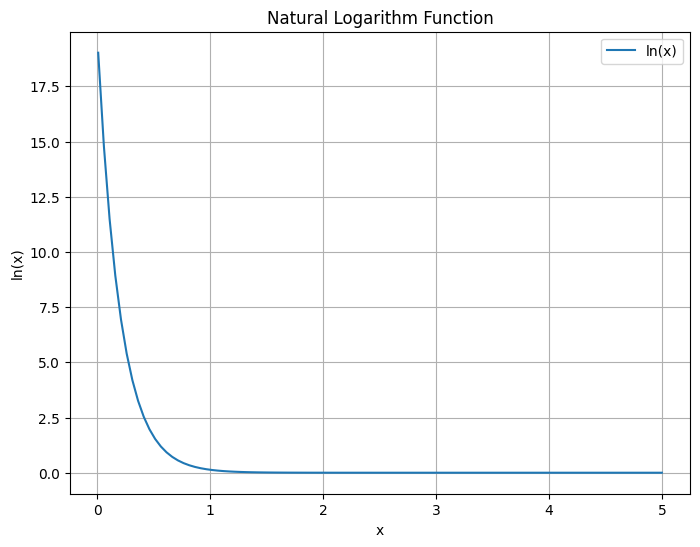

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 0.01에서 10까지의 값을 생성합니다. 0은 로그에 정의되지 않으므로 포함시키지 않습니다.
x = np.linspace(0.01, 5, 100)
y = 20/np.exp(5*x)+0.00001

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ln(x)')

plt.title('Natural Logarithm Function')
plt.xlabel('x')
plt.ylabel('ln(x)')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
20/np.exp(5*0.01)+0.00001

19.02459849001428

In [210]:
from glob import glob
from PIL import Image
import cv2
from tqdm import tqdm

In [232]:
fns = glob("/media/mlfavorfit/sda/template_recommend_dataset/train_origin/*/*")
fns = [cur for idx, cur in enumerate(sorted(fns)) if idx % 2 == 0]

In [233]:
means = np.empty((0,3))
stds = np.empty((0,3))
selected_fns = np.random.choice(fns, 1000)

In [234]:
for fn in tqdm(selected_fns):
    img = np.array(Image.open(fn), dtype=np.uint8)

    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_img_norm = hsv_img / np.array([179, 255, 255])

    flat_hsv = hsv_img_norm.reshape(-1,3)

    mean = np.mean(flat_hsv, axis=0)
    std = np.std(flat_hsv, axis=0)
    
    means = np.append(means, [mean], axis=0)
    stds = np.append(stds, [std], axis=0)

  8%|▊         | 82/1000 [01:26<11:59,  1.28it/s]/home/mlfavorfit/anaconda3/envs/kjg_ver39/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (94089600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 74%|███████▍  | 744/1000 [13:03<05:43,  1.34s/it]/home/mlfavorfit/anaconda3/envs/kjg_ver39/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 90%|█████████ | 904/1000 [15:55<01:52,  1.17s/it]/home/mlfavorfit/anaconda3/envs/kjg_ver39/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (95373558 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1000/1000 [17:44<00:00,  1.06s/it]


In [238]:
np.mean(means, axis=0).astype(np.float16)

array([0.314 , 0.3064, 0.553 ], dtype=float16)

In [239]:
np.mean(stds, axis=0).astype(np.float16)

array([0.2173, 0.2056, 0.2211], dtype=float16)

In [269]:
temp = np.array([
                    [
                        [0,1,2],
                        [0,10,20]
                    ], 
                    [
                        [1,2,3],
                        [100,50,80]
                    ]
                ]
            )
temp.shape

(2, 2, 3)

In [257]:
np.mean(temp, axis=0)

array([[ 0.5,  1.5,  2.5],
       [50. , 30. , 50. ]])

In [ ]:
평균 = [0.314 , 0.3064, 0.553 ]

분산 = [0.2173, 0.2056, 0.2211]

In [1]:
import torch

t = torch.randn(8,4,4)

In [10]:
t[:,0,:].unsqueeze(1).shape

torch.Size([8, 1, 4])

In [3]:
import json

with open("/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_split/train_datas.json", mode="r") as f:
    train_1 = list(json.load(f).values())
with open("/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_split/val_datas.json", mode="r") as f:
    val_1 = list(json.load(f).values())
with open("/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_split/train_labels.json", mode="r") as f:
    train_2 = list(json.load(f).values())
with open("/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_split/val_labels.json", mode="r") as f:
    val_2 = list(json.load(f).values())

In [179]:
total = train_1 + val_1 + train_2 + val_2

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [54]:
class ColorIterDataset(Dataset):
    def __init__(self, datas):
        self.datas = []
        for data in datas:
            try:
                colors = np.array(data[0])/255
                percentage = np.array(data[1]).reshape(-1,1)
                feature = np.concatenate([colors, percentage], axis=1)
                self.datas.append(feature)
            except:
                pass

        print(f"Dataset -> num_of_data:{len(self.datas)}")
    
    def __getitem__(self, idx):
        feature = self.datas[idx]
        return torch.FloatTensor(feature.flatten()), torch.FloatTensor(feature.flatten())

    def __len__(self):
        return len(self.datas)


class ColorIterDataset(Dataset):
    def __init__(self, path):
        fns = glob(os.path.join(path, "*", "*"))
    
        self.datas = [np.array(Image.open(fn).convert("RGB")) for fn in fns]
    def get_colors(self, img_arr):
        img_arr[np.where(img_arr != [0,0,0])]
    def __getitem__(self, idx):

        feature = self.datas[idx]
        return torch.FloatTensor(feature.flatten()), torch.FloatTensor(feature.flatten())

    def __len__(self):
        return len(self.datas)


In [55]:
from torch.nn.functional import interpolate
import torch
def extract_color_pallet(img, mask, size=256):
    img_masked = np.expand_dims(img[np.where(mask>127)].reshape(-1,3), axis=0)
    conpresse_img = interpolate(torch.FloatTensor(img_masked).unsqueeze(0), size=[size,3], mode="bilinear")

    return conpresse_img.squeeze().numpy()


In [15]:
import numpy as np
img_path, mask_path = "/media/mlfavorfit/sda/template_recommend_dataset/train_origin/alcohol/62_afeww.jpg", "/media/mlfavorfit/sda/template_recommend_dataset/train_origin/alcohol/62_afeww_mask.jpg"
img = np.array(Image.open(img_path).resize([128, 128]))
mask = np.array(Image.open(mask_path).resize([128, 128]))

NameError: name 'Image' is not defined

In [9]:
len(img.flatten())

49152

In [10]:
from utils.colors_utils import sort_colors

In [12]:
sort_colors(extract_color_pallet(img, mask).tolist(), reverse=True)

[[181.65625, 104.0, 27.21875],
 [179.890625, 96.921875, 23.984375],
 [179.734375, 99.859375, 25.4375],
 [179.390625, 176.296875, 111.96875],
 [178.140625, 101.265625, 24.0],
 [176.875, 104.03125, 26.0],
 [175.796875, 133.71875, 68.625],
 [174.25, 169.65625, 96.25],
 [170.6875, 152.703125, 98.625],
 [168.9375, 121.53125, 24.0625],
 [165.796875, 104.96875, 15.1875],
 [159.53125, 150.0, 71.53125],
 [159.21875, 152.21875, 74.8125],
 [158.953125, 106.0, 32.640625],
 [158.0, 149.0, 71.078125],
 [157.109375, 149.53125, 76.6875],
 [156.0, 147.0, 70.859375],
 [153.984375, 125.84375, 29.125],
 [153.421875, 146.0, 67.578125],
 [152.765625, 140.203125, 66.53125],
 [151.265625, 144.53125, 63.734375],
 [150.84375, 82.234375, 23.65625],
 [150.578125, 87.0625, 9.5625],
 [149.796875, 142.59375, 63.59375],
 [149.015625, 141.703125, 56.703125],
 [147.609375, 137.484375, 51.828125],
 [143.71875, 135.265625, 50.359375],
 [142.65625, 33.3125, 1.546875],
 [141.578125, 103.0, 20.0],
 [139.96875, 23.828125, 2.

In [227]:
test = torch.FloatTensor([[0,0,0],[127,127,127],[255,255,255]]).unsqueeze(0)

In [228]:
from torch.nn.functional import interpolate
interpolate(test,10, mode="linear").shape

torch.Size([1, 3, 10])

In [244]:
import torch
import torch.nn.functional as F

# 주어진 Tensor
tensor = torch.FloatTensor([[[1, 2, 3], 
                             [4, 5, 6], 
                             [7, 8, 9]]])

# Tensor를 이미지로 변환하고 배치 차원 추가
image_tensor = tensor.unsqueeze(0)
print(image_tensor.shape)
# 보간을 통한 이미지 크기 조절 (세로 차원을 10배로)
interpolated_image_tensor = F.interpolate(image_tensor, size=(10,3), mode='bilinear')

# 결과 출력
print(interpolated_image_tensor.squeeze())


torch.Size([1, 1, 3, 3])
tensor([[1.0000, 2.0000, 3.0000],
        [1.0000, 2.0000, 3.0000],
        [1.7500, 2.7500, 3.7500],
        [2.6500, 3.6500, 4.6500],
        [3.5500, 4.5500, 5.5500],
        [4.4500, 5.4500, 6.4500],
        [5.3500, 6.3500, 7.3500],
        [6.2500, 7.2500, 8.2500],
        [7.0000, 8.0000, 9.0000],
        [7.0000, 8.0000, 9.0000]])


In [182]:
train_num = int(len(total) * 0.7)

train_dataset = ColorIterDataset(total[:train_num])
val_dataset = ColorIterDataset(total[train_num:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=16)

Dataset -> num_of_data:139958
Dataset -> num_of_data:59978


In [16]:
class ColorAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.LayerNorm(latent_dim),
            nn.ReLU(),
        )

        # 디코더 정의
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.Sigmoid()  # RGB 값은 [0, 1] 범위로 제한
        )

    def forward(self, x):
        # 인코더와 디코더 연결
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 모델 생성
latent_dim = 256  # latent space의 차원 설정
model = ColorAutoencoder(16, 256)

In [7]:
def train(model, epoch, loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    for idx, (inputs, labels) in tqdm(enumerate(loader), leave=False, desc=f"Epoch:{epoch} train", total=len(loader)):
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
  
    return running_loss/len(loader)*100
    

def val(model, epoch, loader, criterion):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for idx, (inputs, labels) in tqdm(enumerate(loader), leave=False, desc=f"Epoch:{epoch} val", total=len(loader)):
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()

    return running_loss/len(loader)*100

In [8]:
model.to("cuda")

criterion = nn.MSELoss()

from model.lr_scheduler import CosineAnnealingWarmUpRestarts
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-8)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=2, eta_max=1e-3,  T_up=3, gamma=0.5)

for epoch in range(100):
    train_loss = train(model, epoch, train_loader, optimizer, criterion)
    val_loss = val(model, epoch, val_loader, criterion)
    if val_loss < 0.0005: break
    print(f"\n***Epoch: {epoch}***\ntrain_loss: {train_loss}\nval_loss: {val_loss}\ncur_lr: {scheduler.get_last_lr()}\n")

    scheduler.step()



***Epoch: 0***
train_loss: 8.418318419025255
val_loss: 9.932089215812761
cur_lr: 1e-08




***Epoch: 1***
train_loss: 0.09079089227568085
val_loss: 0.020484403592596963
cur_lr: 0.00033334




***Epoch: 2***
train_loss: 0.021149740557067174
val_loss: 0.012317782750606108
cur_lr: 0.0006666700000000001




***Epoch: 3***
train_loss: 0.015366214656572431
val_loss: 0.014793563227767098
cur_lr: 0.001




***Epoch: 4***
train_loss: 0.00977975106103952
val_loss: 0.00655227345978526
cur_lr: 0.0009504849291068701



KeyboardInterrupt: 

In [126]:
torch.save(model.state_dict(), "encoder.pth")

In [91]:
latent_dim = 256  # latent space의 차원 설정
model = ColorAutoencoder(16, 256)

NameError: name 'ColorAutoencoder' is not defined

In [137]:
encoder = model.encoder
decoder = model.decoder

In [151]:
from utils.colors_utils import visualize_rgb_colors

In [175]:
input = val_dataset[100][0]

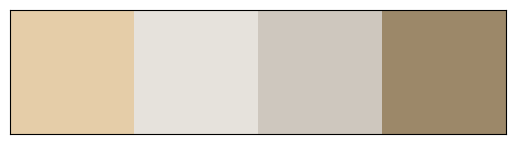

In [176]:
visualize_rgb_colors((input.reshape(-1,4)[:,:3]*255).numpy())

In [177]:
input

tensor([0.8980, 0.8039, 0.6588, 0.4125, 0.9020, 0.8863, 0.8627, 0.2990, 0.8078,
        0.7804, 0.7451, 0.1636, 0.6118, 0.5333, 0.4118, 0.1249])

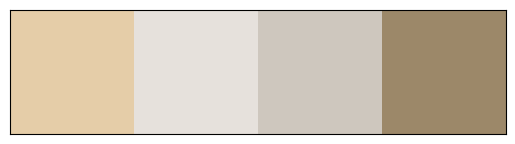

In [178]:
visualize_rgb_colors((model(input.to("cuda")).detach().to("cpu").reshape(-1,4)[:,:3]*255).numpy())

# 추천 학습

In [56]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [57]:
import os
import json

In [58]:
from utils.colors_utils import color_normalization, color_normalization_restore

In [59]:
class CustomActivationFunction(nn.Module):
    def __init__(self):
        super(CustomActivationFunction, self).__init__()

    def forward(self, x):
        # 음수 부분은 0으로 만듭니다.
        negative_part = F.relu(-x)
        
        # 양수 부분은 그대로 사용합니다.
        positive_part = F.relu(x)

        # 음수 부분과 양수 부분을 합칩니다.
        result = negative_part + positive_part

        # 1 이상인 부분을 1로 만듭니다.
        result = torch.where(result >= 1, torch.tensor(1.0), result)

        return result

In [137]:
class EmbedDataset(Dataset):
    def __init__(self, data_json_path, label_json_path, encoder, device = "cuda"):
        self.device = device

        encoder.to(device)
        encoder.eval()
        self.encoder = encoder

        with open(os.path.join(data_json_path), mode="r") as f:
            data_map = json.load(f)

        with open(os.path.join(label_json_path), mode="r") as f:
            label_map = json.load(f)
        
        map_keys = [cur for cur in sorted(label_map.keys()) if label_map[cur][0] != "Error" and data_map[cur][0] != "Error"]

        self.datas = [
                        (key,
                         self.embed(data_map[key]),
                        #  self.embed(label_map[key]), 
                         torch.FloatTensor(color_normalization(label_map[key][0], scaling=True, type="rgb").flatten()),
                         label_map[key][2]
                         ) 
                        for key in map_keys
                    ]


        print(f"Dataset -> data_path:{data_json_path}, num_of_data:{len(self.datas)}")


    def embed(self, data):
        try:
            colors = np.array(data[0])/255
            percentage = np.array(data[1]).reshape(-1,1)
            feature = np.concatenate([colors, percentage], axis=1)
        except:
            print(data)
        return self.encoder(torch.FloatTensor(feature.flatten()).to(self.device)).detach().to("cpu")
    
    def __getitem__(self, idx):
        key, data, label, weight_key = self.datas[idx]
        return key, data, label, [str(cur) for cur in weight_key]

    def __len__(self):
        return len(self.datas)

In [61]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x) + x
    

class EmbedNet(nn.Module):
    def __init__(self, input_size, output_size, inter_num=3, hidden_dims=[128, 64]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, hidden_dims[0])


        module = []
        in_size = hidden_dims[0]
        for ex_dim in hidden_dims[1:]:
            module.append(nn.Sequential(
                                nn.Linear(in_size, ex_dim),
                                nn.LayerNorm(ex_dim),
                                nn.ReLU(),
                            ))
            in_size = ex_dim
        self.expander = nn.Sequential(*module)


        module = []
        for _ in range(inter_num):
            module.append(nn.Sequential(
                                ResidualBlock(hidden_dims[-1]),
                                # nn.Dropout(0.3),
                            ))
        self.intermediate = nn.Sequential(*module)
        self.dropout = nn.Dropout(0.3)

        module = []
        in_size = hidden_dims[-1]
        for re_dim in reversed(hidden_dims[:-1]):
            module.append(nn.Sequential(
                                nn.Linear(in_size, re_dim),
                                nn.LayerNorm(re_dim),
                                nn.ReLU(),
                            ))
            in_size = re_dim
        self.reducer = nn.Sequential(*module)


        self.last_layer = nn.Sequential(
                                nn.Linear(hidden_dims[0], output_size),
                                )


    def forward(self, x):
        x = self.first_layer(x)
        x = self.expander(x)
        x = self.dropout(x)
        x = self.intermediate(x)
        x = self.reducer(x)
        x = self.last_layer(x)
        return x

In [62]:
class ResCatBlock(nn.Module):
    def __init__(self, input_dim, output_dim, iter_dim = 1):
        super().__init__()
        if output_dim % 2 == 1:
            raise ValueError

        out_dim_prev_concat = int(output_dim/2)

        self.block = nn.Sequential(
            nn.Linear(input_dim, out_dim_prev_concat),
            nn.LayerNorm(out_dim_prev_concat),
            nn.ReLU(),
        )

        module = []
        for _ in range(iter_dim):
            module.append(nn.Sequential(
                nn.Linear(out_dim_prev_concat, out_dim_prev_concat),
                nn.LayerNorm(out_dim_prev_concat),
                nn.ReLU(),
            ))
        self.iter = nn.Sequential(*module)
        
        self.shortcur = nn.Sequential(
            nn.Linear(input_dim, out_dim_prev_concat),
            nn.LayerNorm(out_dim_prev_concat),
            nn.ReLU(),
        )

    def forward(self, x):
        y = self.block(x)
        y = self.iter(y)
        res = self.shortcur(x)
        return torch.concat((y, res), dim=1)

class ResLinearNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims=[256, 128, 64, 32]):
        super().__init__()

        self.dropout = nn.Dropout(0.3)
        self.first_layer = nn.Linear(input_size, hidden_dims[0])


        module = []
        in_size = hidden_dims[0]
        for ex_dim in hidden_dims[1:]:
            module.append(nn.Sequential(
                nn.Linear(in_size, ex_dim),
                nn.LayerNorm(ex_dim),
                nn.ReLU(),
                # ResCatBlock(in_size, ex_dim),
                ))
            in_size = ex_dim
        self.reducer = nn.Sequential(*module)


        self.last_layer = nn.Sequential(
                                nn.Linear(hidden_dims[-1], output_size),
                                )


    def forward(self, x):
        x = self.first_layer(x)
        x = self.reducer(x)
        x = self.last_layer(x)
        return x

In [63]:
class EmbedVAE(nn.Module):
    def __init__(self, input_size, output_size, latent_dim, inter_num=3, hidden_dims=[128, 64]):
        super().__init__()

        # 첫 번째 계층
        self.first_layer = nn.Linear(input_size, hidden_dims[0])

        # 확장 계층
        module = []
        in_size = hidden_dims[0]
        for ex_dim in hidden_dims[1:]:
            module.append(nn.Sequential(
                nn.Linear(in_size, ex_dim),
                nn.LayerNorm(ex_dim),
                nn.ReLU(),
            ))
            in_size = ex_dim
        self.expander = nn.Sequential(*module)

        # 중간 계층 (intermediate)
        module = []
        for _ in range(inter_num):
            module.append(nn.Sequential(
                ResidualBlock(hidden_dims[-1]),
                # nn.Dropout(0.5),
            ))
        self.intermediate = nn.Sequential(*module)

        # 인코더의 평균과 로그 분산 계층
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # 디코더의 첫 번째 계층
        self.fc_decode = nn.Linear(latent_dim, hidden_dims[-1])

        # 축소 계층
        module = []
        in_size = hidden_dims[-1]
        for re_dim in reversed(hidden_dims[:-1]):
            module.append(nn.Sequential(
                nn.Linear(in_size, re_dim),
                nn.LayerNorm(re_dim),
                nn.ReLU(),
            ))
            in_size = re_dim
        self.reducer = nn.Sequential(*module)

        # 마지막 계층
        self.last_layer = nn.Sequential(
            nn.Linear(hidden_dims[0], output_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.first_layer(x)
        x = self.expander(x)
        # x = self.intermediate(x)

        # 인코더를 통한 잠재 공간의 평균과 로그 분산 계산
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # 리파라미터화 트릭 적용
        z = self.reparameterize(mu, logvar)

        # 디코더를 통한 데이터 재구성
        x = self.fc_decode(z)
        x = self.reducer(x)
        x = self.last_layer(x)
        return x, mu, logvar

In [64]:
model = ColorAutoencoder(16, 256)

state_path = "./encoder.pth"
model.load_state_dict(torch.load(state_path, map_location="cpu"))

encoder = model.encoder
decoder = model.decoder

In [75]:
class PalletDataset(Dataset):
    def __init__(self, data_json_path, label_json_path):
        with open(os.path.join(data_json_path), mode="r") as f:
            data_map = json.load(f)

        with open(os.path.join(label_json_path), mode="r") as f:
            label_map = json.load(f)

        map_keys = [cur for cur in sorted(label_map.keys()) if label_map[cur][0] != "Error" and data_map[cur][0] != "Error"]

        self.datas = [
                        (key,
                        data_map[key],
                        self.concat_colors_percentaget(label_map[key][0], label_map[key][1]),
                        label_map[key][2]
                        ) 
                        for key in map_keys
                    ]
        
        print(f"Dataset -> data_path:{data_json_path}, num_of_data:{len(self.datas)}")

    def concat_colors_percentaget(self, colors, perc):
        colors_t = torch.FloatTensor(colors)
        perc_t = torch.FloatTensor(perc).unsqueeze(0).permute([1,0])
        return torch.concatenate((colors_t, perc_t), 1)

    def __getitem__(self, idx):

        key, pallet, label, weight_key = self.datas[idx]
        return key, torch.FloatTensor(pallet).flatten(), torch.FloatTensor(label).flatten(), [str(cur) for cur in weight_key]

    def __len__(self):
        return len(self.datas)

In [138]:
train_dataset = EmbedDataset(data_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/train_datas.json",
                             label_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/train_labels.json",
                             encoder=encoder,
                             device="cuda")
val_dataset = EmbedDataset(data_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/val_datas.json",
                             label_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/val_labels.json",
                             encoder=encoder,
                             device="cuda")
# train_dataset = PalletDataset(data_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/train_pallet.json", 
#                               label_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/train_labels.json")
# val_dataset = PalletDataset(data_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/val_pallet.json", 
#                             label_json_path="/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/val_labels.json")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=16)

Dataset -> data_path:/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/train_datas.json, num_of_data:69976
Dataset -> data_path:/media/mlfavorfit/sda/template_recommend_dataset/cluster_features_quantization/val_datas.json, num_of_data:29991


In [146]:
# model = EmbedNet(256, 256, inter_num=3, hidden_dims=[128,64])
# model = EmbedVAE(256, 256, latent_dim=64, inter_num=3, hidden_dims=[128,64])
model = ResLinearNet(256, 12, hidden_dims=[256, 128, 64, 32])

In [147]:
def train(model, epoch, loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    for idx, (key, inputs, labels, weight_key) in tqdm(enumerate(loader), leave=False, desc=f"Epoch:{epoch} train", total=len(loader)):
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        outputs = model(inputs)
        # outputs, mu, logvar = model(inputs)
        loss = criterion(outputs, labels, weight_key)
        # loss = criterion(outputs, labels, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
  
    return running_loss/len(loader)*100
    

def val(model, epoch, loader, criterion):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for idx, (key, inputs, labels, weight_key) in tqdm(enumerate(loader), leave=False, desc=f"Epoch:{epoch} val", total=len(loader)):
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            outputs = model(inputs)
            # outputs, mu, logvar = model(inputs)
            loss = criterion(outputs, labels, weight_key)
            # loss = criterion(outputs, labels, mu, logvar)
            
            running_loss += loss.item()

    return running_loss/len(loader)*100

In [150]:
import torch.nn.functional as F

class MSEKLDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return recon_loss + kld_loss
    
class VarianceSensitiveMSELoss(nn.Module):
    def __init__(self, gamma: float = 0.5) -> None:
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        i_colors = input.reshape(-1,4,4)[:,:,:3].reshape(-1,12)
        # hue__val_i_colors = input.reshape(-1,4,4)[:,:,[0,2]].reshape(-1,8)
        # hue__val_t_colors = target.reshape(-1,4,4)[:,:,[0,2]].reshape(-1,8)

        mse_loss = F.mse_loss(input, target)
        # hv_loss = F.mse_loss(hue__val_i_colors, hue__val_t_colors)

        variance_color = torch.var(i_colors, dim=1).mean()
        variance_batch = torch.var(i_colors, dim=0).mean()
        
        # vc_loss = self.gamma *(3/torch.exp(0.5*variance_color)+0.00001)
        # vb_loss = self.gamma *(3/torch.exp(0.5*variance_batch)+0.00001)
        vc_loss = self.gamma *(20/torch.exp(5*variance_color)+0.00001)
        vb_loss = self.gamma *(20/torch.exp(5*variance_batch)+0.00001)
        # vc_loss = -self.gamma*variance_color + self.gamma/2
        # vb_loss = -self.gamma*variance_batch + self.gamma/2

        return mse_loss + vc_loss + vb_loss # + hv_loss
    
class WeightedHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(WeightedHuberLoss, self).__init__()

        with open("./main_color_weights_map.json", mode="r") as f:
            weights_map = json.load(f)
            self.weights_map ={cur:1/weights_map[cur] for cur in weights_map}
        self.delta = delta

    def calculate_cos_similarity(target, data_arr):
        target = np.array(target) / np.linalg.norm(target)
        data_arr = np.array(data_arr) / np.linalg.norm(data_arr, axis=1)[:,None]
        cos_sim = np.matmul(target, data_arr.T)[0]

        cos_sim[np.isnan(cos_sim)] = 0
        return cos_sim

    def forward(self, y_true, y_pred, weights_key):
        weights = torch.FloatTensor([[[self.weights_map[key]] for key in t] for t in weights_key])
        weights = torch.cat([weights,weights,weights], dim=1).reshape(-1,12).to("cuda")
        residual = torch.abs(y_true - y_pred)
        huber_loss = torch.where(residual < self.delta,
                                 0.5 * residual ** 2,
                                 self.delta * (residual - 0.5 * self.delta))
        weighted_huber_loss = huber_loss * (weights)

        return torch.mean(weighted_huber_loss)

In [151]:
model.to("cuda")

# criterion = nn.HuberLoss(delta=1.5)
# criterion = VarianceSensitiveMSELoss(0.1)
# criterion = nn.MSELoss()
criterion = WeightedHuberLoss(delta=1)
# criterion = MSEKLDLoss()

from model.lr_scheduler import CosineAnnealingWarmUpRestarts
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-8)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=2, eta_max=1e-3,  T_up=3, gamma=0.5)

for epoch in range(100):
    train_loss = train(model, epoch, train_loader, optimizer, criterion)
    val_loss = val(model, epoch, val_loader, criterion)
    
    print(f"\n***Epoch: {epoch}***\ntrain_loss: {train_loss}\nval_loss: {val_loss}\ncur_lr: {scheduler.get_last_lr()}\n")

    scheduler.step()


***Epoch: 0***
train_loss: 839.5220003718921
val_loss: 854.7278896204631
cur_lr: 1e-08




***Epoch: 1***
train_loss: 842.9077095591865
val_loss: 860.7512247339886
cur_lr: 0.00033334




***Epoch: 2***
train_loss: 842.195765627101
val_loss: 856.3752764256795
cur_lr: 0.0006666700000000001




***Epoch: 3***
train_loss: 847.3332027812281
val_loss: 861.0902151298524
cur_lr: 0.001




***Epoch: 4***
train_loss: 843.2822872036714
val_loss: 863.1713615671794
cur_lr: 0.0009504849291068701




***Epoch: 5***
train_loss: 843.8076897413152
val_loss: 858.789822654724
cur_lr: 0.0008117467834803576




***Epoch: 6***
train_loss: 842.9426386495894
val_loss: 852.8631490325928
cur_lr: 0.0006112643543734875




***Epoch: 7***
train_loss: 839.3256025495298
val_loss: 853.9067956606547
cur_lr: 0.0003887456456265126




***Epoch: 8***
train_loss: 838.8876496301048
val_loss: 850.340324751536
cur_lr: 0.00018826321651964256




***Epoch: 9***
train_loss: 834.2010022408896
val_loss: 849.0334414291383
cur_lr: 4.952507089313e-05




***Epoch: 10***
train_loss: 834.600013524471
val_loss: 849.0326376978556
cur_lr: 1e-08




***Epoch: 11***
train_loss: 832.2757293685255
val_loss: 850.9141128158569
cur_lr: 0.00016667333333333332




***Epoch: 12***
train_loss: 835.9702047933222
val_loss: 850.3778407796224
cur_lr: 0.00033333666666666664




***Epoch: 13***
train_loss: 839.8325056832405
val_loss: 852.3022554651897
cur_lr: 0.0005




***Epoch: 14***
train_loss: 836.652309152161
val_loss: 849.9496786880494
cur_lr: 0.0004937321034058949




***Epoch: 15***
train_loss: 835.305470716043
val_loss: 850.5471445274352
cur_lr: 0.0004752427121312652




***Epoch: 16***
train_loss: 835.9910078690812
val_loss: 850.8226882743836
cur_lr: 0.0004454589614595951




***Epoch: 17***
train_loss: 832.5831183817052
val_loss: 847.6059150187174
cur_lr: 0.0004058743330156741




***Epoch: 18***
train_loss: 833.2521479534241
val_loss: 847.4620736122132
cur_lr: 0.00035847376536069387




***Epoch: 19***
train_loss: 833.7097496543784
val_loss: 845.5409113121032
cur_lr: 0.00030563412088440876




***Epoch: 20***
train_loss: 827.5839349124658
val_loss: 845.0149415270488
cur_lr: 0.000250005




***Epoch: 21***
train_loss: 829.738177504232
val_loss: 845.7568266677857
cur_lr: 0.00019437587911559116




***Epoch: 22***
train_loss: 829.3431048040036
val_loss: 843.1292111206055
cur_lr: 0.00014153623463930605




***Epoch: 23***
train_loss: 825.3070118686736
val_loss: 845.499665590922
cur_lr: 9.413566698432592e-05




***Epoch: 24***
train_loss: 826.6880356317031
val_loss: 843.358896414439
cur_lr: 5.455103854040497e-05




***Epoch: 25***
train_loss: 827.8884276059538
val_loss: 842.5506027285257
cur_lr: 2.476728786873475e-05




***Epoch: 26***
train_loss: 829.5511043311583
val_loss: 842.5988316218059
cur_lr: 6.277896594104976e-06




***Epoch: 27***
train_loss: 827.8394482099797
val_loss: 842.5987333424887
cur_lr: 1e-08




***Epoch: 28***
train_loss: 826.9444056281119
val_loss: 844.6604924647014
cur_lr: 8.334e-05




***Epoch: 29***
train_loss: 829.104772339578
val_loss: 845.1535362434388
cur_lr: 0.00016667




***Epoch: 30***
train_loss: 826.8729773650281
val_loss: 845.2813528696696
cur_lr: 0.00025




***Epoch: 31***
train_loss: 828.6297531939011
val_loss: 845.724665883382
cur_lr: 0.00024921405767560587




***Epoch: 32***
train_loss: 828.7178627911582
val_loss: 849.651392141978
cur_lr: 0.00024686611438316705




***Epoch: 33***
train_loss: 828.8524692277687
val_loss: 845.2498347727458
cur_lr: 0.0002429856968718944




***Epoch: 34***
train_loss: 829.5485295276965
val_loss: 848.2472765604655
cur_lr: 0.00023762160364346286




***Epoch: 35***
train_loss: 828.4359454836101
val_loss: 844.8706875483194
cur_lr: 0.00023084129128253937




***Epoch: 36***
train_loss: 828.5255058639171
val_loss: 843.0876594734192
cur_lr: 0.00022273002615109141




***Epoch: 37***
train_loss: 825.9023091484544
val_loss: 844.8306616338094
cur_lr: 0.0002133898121144125




***Epoch: 38***
train_loss: 826.7481672284154
val_loss: 844.8296969985963
cur_lr: 0.00020293810778333242




***Epoch: 39***
train_loss: 827.8188949831556
val_loss: 846.8552357673644
cur_lr: 0.0001915063494040345




***Epoch: 40***
train_loss: 827.1135594864442
val_loss: 845.2725190798441
cur_lr: 0.00017923829797099916




***Epoch: 41***
train_loss: 824.2110231967075
val_loss: 844.8947433662415
cur_lr: 0.00016628823134908613




***Epoch: 42***
train_loss: 825.5890580225491
val_loss: 846.8105479303995
cur_lr: 0.00015281900413986952




***Epoch: 43***
train_loss: 823.3835800548749
val_loss: 843.487953484853
cur_lr: 0.00013899999969053294




***Epoch: 44***
train_loss: 822.1592885830875
val_loss: 842.1995806884765
cur_lr: 0.000125005




***Epoch: 45***
train_loss: 821.2293237570382
val_loss: 842.2161718114218
cur_lr: 0.00011101000030946706




***Epoch: 46***
train_loss: 821.553211720174
val_loss: 845.5426391537983
cur_lr: 9.71909958601305e-05




***Epoch: 47***
train_loss: 820.3850021687174
val_loss: 842.3815231704712
cur_lr: 8.372176865091387e-05




***Epoch: 48***
train_loss: 821.8803422768257
val_loss: 844.4626654815673
cur_lr: 7.077170202900083e-05




***Epoch: 49***
train_loss: 821.5935050187505
val_loss: 842.9614002418518
cur_lr: 5.850365059596552e-05




***Epoch: 50***
train_loss: 817.8858313786149
val_loss: 842.9022108586629
cur_lr: 4.707189221666761e-05




***Epoch: 51***
train_loss: 818.930843209479
val_loss: 842.350022500356
cur_lr: 3.6620187885587505e-05




***Epoch: 52***
train_loss: 819.9013534860084
val_loss: 842.3704529253642
cur_lr: 2.727997384890866e-05




***Epoch: 53***
train_loss: 820.5498998084458
val_loss: 842.4352625656129
cur_lr: 1.9168708717460627e-05




***Epoch: 54***
train_loss: 818.6167113220632
val_loss: 842.4909125010172
cur_lr: 1.2388396356537134e-05




***Epoch: 55***
train_loss: 815.9638850368426
val_loss: 842.4868203226727
cur_lr: 7.0243031281055955e-06




***Epoch: 56***
train_loss: 817.986175749037
val_loss: 842.302827606201
cur_lr: 3.143885616832943e-06




***Epoch: 57***
train_loss: 818.4844789572596
val_loss: 842.2644783465067
cur_lr: 7.959423243941407e-07




***Epoch: 58***
train_loss: 818.8876901988739
val_loss: 842.2647179476421
cur_lr: 1e-08




***Epoch: 59***
train_loss: 820.0782283234389
val_loss: 842.4752733230591
cur_lr: 4.167333333333334e-05




***Epoch: 60***
train_loss: 819.1921914583153
val_loss: 843.5473521296183
cur_lr: 8.333666666666667e-05




***Epoch: 61***
train_loss: 823.3710683286054
val_loss: 844.5365215937297
cur_lr: 0.000125




***Epoch: 62***
train_loss: 821.7507148557565
val_loss: 843.1504744784038
cur_lr: 0.00012490168380453845




***Epoch: 63***
train_loss: 818.8701722874836
val_loss: 844.1517477226258
cur_lr: 0.00012460704455727822




***Epoch: 64***
train_loss: 820.6034033904622
val_loss: 842.5672165171304
cur_lr: 0.00012411700930229714




***Epoch: 65***
train_loss: 819.872280457928
val_loss: 843.8737389691671
cur_lr: 0.00012343311987180307




***Epoch: 66***
train_loss: 818.6365036180589
val_loss: 844.2484839566548
cur_lr: 0.00012255752803495902




***Epoch: 67***
train_loss: 818.942427924086
val_loss: 842.0429932594299
cur_lr: 0.00012149298872762143




***Epoch: 68***
train_loss: 820.3287322552825
val_loss: 844.971628519694
cur_lr: 0.00012024285138429286




***Epoch: 69***
train_loss: 819.9941091058895
val_loss: 844.9283577537537
cur_lr: 0.00011881104939956168




***Epoch: 70***
train_loss: 816.3512098309544
val_loss: 844.2557140223184
cur_lr: 0.00011720208775218758




***Epoch: 71***
train_loss: 818.3208653138662
val_loss: 842.2861582438151
cur_lr: 0.00011542102883077162




***Epoch: 72***
train_loss: 819.2672808774269
val_loss: 843.3970861307779
cur_lr: 0.00011347347650560897




***Epoch: 73***
train_loss: 820.2585813330905
val_loss: 845.2100510533651
cur_lr: 0.00011136555849683953




***Epoch: 74***
train_loss: 816.4899526173305
val_loss: 842.7541994857788
cur_lr: 0.00010910390709437343




***Epoch: 75***
train_loss: 818.3327084052056
val_loss: 843.8441828473408
cur_lr: 0.00010669563829025329




***Epoch: 76***
train_loss: 819.281368769082
val_loss: 842.8771425056457
cur_lr: 0.00010414832938911049




***Epoch: 77***
train_loss: 817.6250233680731
val_loss: 842.9897627385458
cur_lr: 0.00010146999516716155




***Epoch: 78***
train_loss: 818.4591312603586
val_loss: 844.2858121617635
cur_lr: 9.866906265475697e-05




***Epoch: 79***
train_loss: 818.1065452469502
val_loss: 843.620398902893
cur_lr: 9.575434462182595e-05




***Epoch: 80***
train_loss: 819.0055791160861
val_loss: 841.6664813359578
cur_lr: 9.273501184964197e-05




***Epoch: 81***
train_loss: 816.8229086054588
val_loss: 842.6699933052064
cur_lr: 8.962056427615179e-05




***Epoch: 82***
train_loss: 815.0640756532271
val_loss: 843.1214390309652
cur_lr: 8.642080110565629e-05




***Epoch: 83***
train_loss: 813.8145698277874
val_loss: 842.7149248377482
cur_lr: 8.314578997688818e-05




***Epoch: 84***
train_loss: 814.1153392559543
val_loss: 843.7031227111817
cur_lr: 7.980583528649596e-05




***Epoch: 85***
train_loss: 814.2742183146327
val_loss: 843.4420186551412
cur_lr: 7.641144576759986e-05




***Epoch: 86***
train_loss: 811.3004295668976
val_loss: 842.9339469210307
cur_lr: 7.29733014254295e-05




***Epoch: 87***
train_loss: 814.4624786966731
val_loss: 843.9219609896343
cur_lr: 6.950221993407621e-05




***Epoch: 88***
train_loss: 810.5235870183195
val_loss: 843.3479012298584
cur_lr: 6.60091226000883e-05




***Epoch: 89***
train_loss: 812.201126830786
val_loss: 842.3247231356303
cur_lr: 6.2505e-05




***Epoch: 90***
train_loss: 811.3091588320119
val_loss: 842.7797080103555
cur_lr: 5.900087739991171e-05




***Epoch: 91***
train_loss: 813.3073537029193
val_loss: 842.986203358968
cur_lr: 5.55077800659238e-05




***Epoch: 92***
train_loss: 812.7521831339552
val_loss: 842.115009988149
cur_lr: 5.203669857457051e-05




***Epoch: 93***
train_loss: 812.1737738722908
val_loss: 843.6267262649537
cur_lr: 4.859855423240014e-05




***Epoch: 94***
train_loss: 809.8442828077456
val_loss: 843.1986404736837
cur_lr: 4.520416471350405e-05




***Epoch: 95***
train_loss: 807.9215056911472
val_loss: 843.0360810279847
cur_lr: 4.186421002311183e-05




***Epoch: 96***
train_loss: 810.7454464704848
val_loss: 843.0466056569417
cur_lr: 3.858919889434372e-05




***Epoch: 97***
train_loss: 809.759962798582
val_loss: 843.3169338353474
cur_lr: 3.538943572384821e-05




***Epoch: 98***
train_loss: 807.4876649171509
val_loss: 842.4031012852987
cur_lr: 3.2274988150358044e-05




***Epoch: 99***
train_loss: 809.501245087775
val_loss: 842.7748207410177
cur_lr: 2.925565537817405e-05



In [167]:
from utils.colors_utils import visualize_rgb_colors

def pipeline_emb(x):
    decoder.eval()
    y = decoder(x)
    print(y.reshape(-1,4)[:,3])
    y = y.reshape(-1,4)[:,:3]
    y = np.array(y.detach().to("cpu")*255)
    visualize_rgb_colors(y)

def pipeline(x):
    # print(x)
    # x = x.reshape(-1,4)[:,:3] 
    visualize_rgb_colors(x)

tensor([0.4104, 0.2613, 0.1979, 0.1314], grad_fn=<SelectBackward0>)


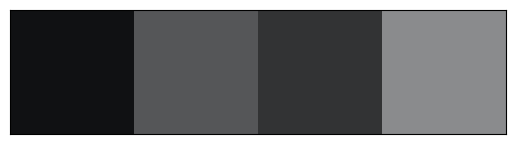

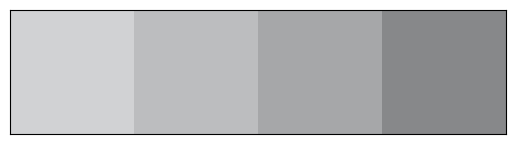

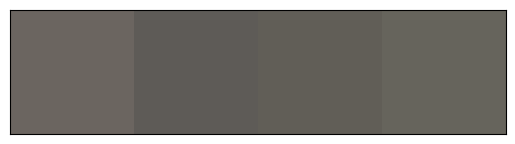

In [195]:
target_index = 30
pipeline_emb(val_dataset[target_index][1])
pipeline(color_normalization_restore(val_dataset[target_index][2].reshape(-1,3)))
pipeline(color_normalization_restore(model(val_dataset[target_index][1].to("cuda")).detach().to("cpu").reshape(-1,3)))

In [ ]:
val_dataset[target_index][0]

In [298]:
train_data = train_1
train_label = train_2
val_data = val_1
val_label = val_2

In [299]:
import matplotlib.pyplot as plt
from utils.colors_utils import *

In [300]:
import numpy as np

In [309]:
tt = np.array([cur[0] for cur in train_label if len(cur[0]) == 4])
temp = tt.reshape(-1,3)

In [69]:
def visualize_scatter(rgb_list):
    rgb_data = np.array(rgb_list)

    # Normalize the RGB values to [0, 1]
    normalized_rgb_data = rgb_data / 255.0

    # Create 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(rgb_data[:, 0], rgb_data[:, 1], rgb_data[:, 2], c=normalized_rgb_data)

    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')

    plt.show()

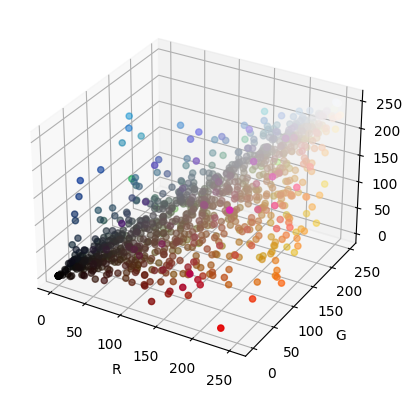

In [70]:
visualize_scatter(temp[np.random.choice(range(len(temp)), 1000)])

In [302]:
targets = temp.reshape(-1,3)
labels_dummy = [0]*len(targets)

In [351]:
color_var = np.mean(np.std(tt, axis=1), axis=1)

In [383]:
from collections import Counter
counter = Counter(np.round(color_var/10).astype(np.uint8))
aaa = (np.array([cur[1] for cur in sorted(counter.items(), key=lambda x:x[0])]) / len(color_var)).astype(np.float16)
{idx:cur for idx, cur in enumerate(aaa)}

{0: 0.02829,
 1: 0.0835,
 2: 0.1088,
 3: 0.1207,
 4: 0.1488,
 5: 0.1838,
 6: 0.1653,
 7: 0.0919,
 8: 0.03046,
 9: 0.011734,
 10: 0.01372,
 11: 0.0129}

In [368]:
np.argmax(color_var)

896

In [342]:
np.argmin(color_var)

763

In [346]:
np.argsort(color_var)[-1]

19105

[[147 110  77]
 [180 165 145]
 [ 63  54  55]
 [103 105 106]]


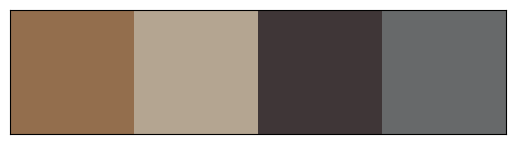

In [350]:
print(tt[0])
visualize_rgb_colors(tt[0].reshape(4,3))

(array([ 5184.,  7887.,  9015., 11040., 14029., 12510.,  6149.,  1785.,
          826.,  1551.]),
 array([  0.        ,  10.99852263,  21.99704526,  32.99556788,
         43.99409051,  54.99261314,  65.99113577,  76.9896584 ,
         87.98818102,  98.98670365, 109.98522628]),
 <BarContainer object of 10 artists>)

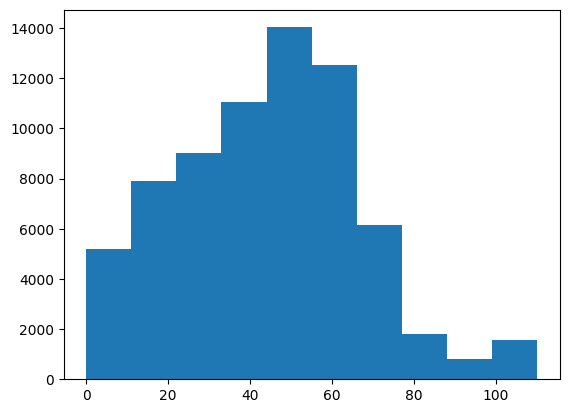

In [333]:
plt.hist(color_var)

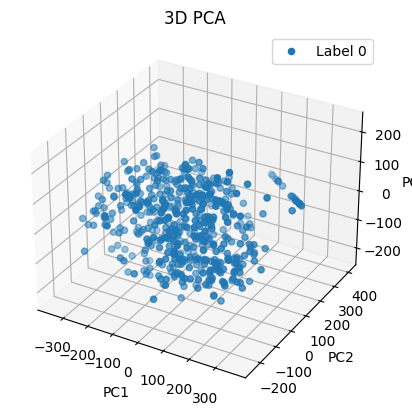

In [87]:
plot_3D_PCA(targets, labels_dummy)